In [37]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from functions import prepare_data
import tensorflow as tf
import sys

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
from model import build_AE, build_VAE




In [2]:
input_file = "/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/QCD_preprocessed.h5"
input_bsm = "/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/BSM_preprocessed.h5"
events = 10000
output_file = "data.pickle"
retun_data = True
# X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_file, input_bsm, events, output_file,retun_data)
with open("data-for-dnn-v2.pickle", 'rb') as f:
    X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler = pickle.load(f)

In [3]:
model_type= 'AE'
latent_dim=3
output_model_h5= "output_model.h5"
output_model_json= "output_model.json"
output_history= "history.h5"
batch_size= 1024*64
n_epochs = 20

if(model_type=='VAE'):
    encoder,decoder = build_VAE(X_train_flatten.shape[-1],latent_dim)
    model = VAE(encoder, decoder)
    model.compile(optimizer=keras.optimizers.Adam())
else:
    autoencoder = build_AE(X_train_flatten.shape[-1],latent_dim)
    model = AE(autoencoder)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    
callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(NeptuneMonitor())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

print("TRAINING")
history = model.fit(X_train_flatten, X_train_scaled, 
                    epochs = n_epochs, 
                    batch_size = batch_size,
                    validation_split=0.2,
                    callbacks=callbacks)

2022-02-07 10:08:38.744141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/uscms/home/abhijith/nobackup/miniconda3/lib/
2022-02-07 10:08:38.744194: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-07 10:08:38.745133: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with t

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 batch_normalization (BatchN  (None, 57)               228       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528   

In [4]:
bsm_labels = ['VectorZPrimeToQQ__M50',
                  'VectorZPrimeToQQ__M100',
                  'VectorZPrimeToQQ__M200',
                  'VBF_HToInvisible_M125',
                  'VBF_HToInvisible_M125_private',
                  'ZprimeToZH_MZprime1000',
                  'ZprimeToZH_MZprime800',
                  'ZprimeToZH_MZprime600',
                  'GluGluToHHTo4B',
                  'HTo2LongLivedTo4mu_1000',
                  'HTo2LongLivedTo4mu_125_12',
                  'HTo2LongLivedTo4mu_125_25',
                  'HTo2LongLivedTo4mu_125_50',
                  'VBFHToTauTau',
                  'VBF_HH']

        loss  val_loss     lr  epoch
15  0.915996  0.924275  0.001     15
16  0.910919  0.915580  0.001     16
17  0.906172  0.919708  0.001     17
18  0.903125  0.905558  0.001     18
19  0.900209  0.905474  0.001     19


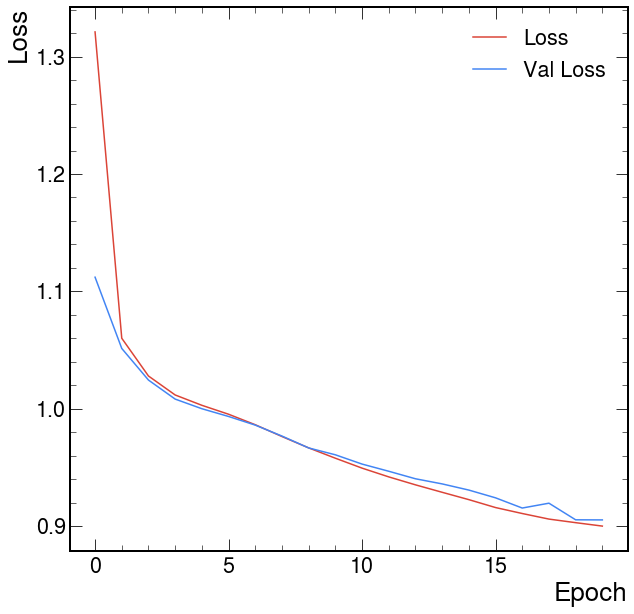

In [5]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())
plt.plot(hist.index.to_numpy(),hist['loss'],label='Loss')
plt.plot(hist.index.to_numpy(),hist['val_loss'],label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
output_result=''

def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

loss = make_mse_loss_numpy
qcd_prediction = model.autoencoder(X_test_scaled).numpy()
results={}
min_loss,max_loss=1e5,0
for i, label in enumerate(bsm_labels):
    results[label] = {}
    bsm_pred = model.autoencoder(bsm_data[i]).numpy()
    results[label]['target'] = bsm_target[i]
    results[label]['prediction'] = bsm_pred
    total_loss = return_total_loss(loss, bsm_target[i], bsm_pred)
    total_loss.shape
    if(np.min(total_loss)<min_loss): min_loss = np.min(total_loss)
    if(np.max(total_loss)>max_loss): max_loss = np.max(total_loss)
    results[label]['loss'] = total_loss

results['QCD'] = {}
results['QCD']['target'] = X_test_scaled
results['QCD']['prediction'] = qcd_prediction
results['QCD']['loss'] = return_total_loss(loss, X_test_scaled, qcd_prediction)

if(output_result!=''):
    h5f = h5py.File(output_result, 'w')
    h5f.create_dataset('loss', data=hist['loss'].to_numpy())
    h5f.create_dataset('val_loss', data=hist['val_loss'].to_numpy())
    h5f.create_dataset('QCD_input', data=X_test_flatten)
    h5f.create_dataset('QCD_target', data=X_test_scaled)
    h5f.create_dataset('predicted_QCD', data = qcd_prediction)
    for i, key in enumerate(results):
        if(key=='QCD'): continue
        h5f.create_dataset('%s_scaled' %key, data=results[key]['target'])
        h5f.create_dataset('%s_input' %key, data=bsm_data[i])
        h5f.create_dataset('predicted_%s' %key, data=results[key]['prediction'])
    print("*** OutputFile Created")
    h5f.close() 

In [30]:
max_loss

479.63477

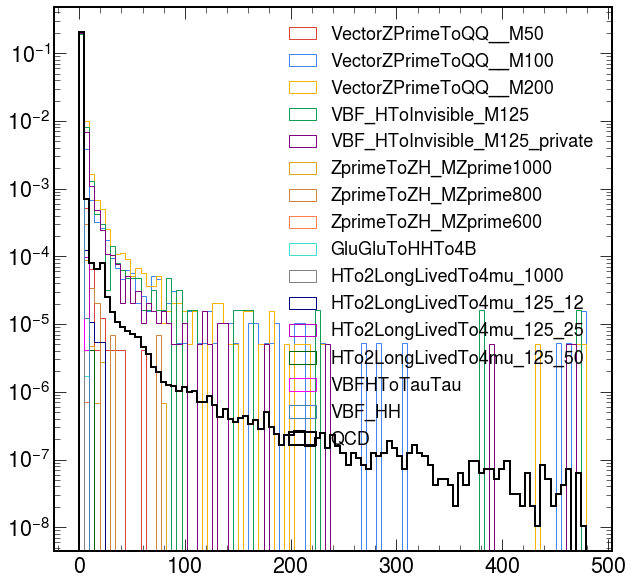

In [38]:
bins_=np.linspace(min_loss,max_loss,100)
plt.figure(figsize=(10,10))
for key in results.keys():
    if(key=='QCD'): plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')

Text(0.5, 1.0, 'ROC curve AE.pdf')

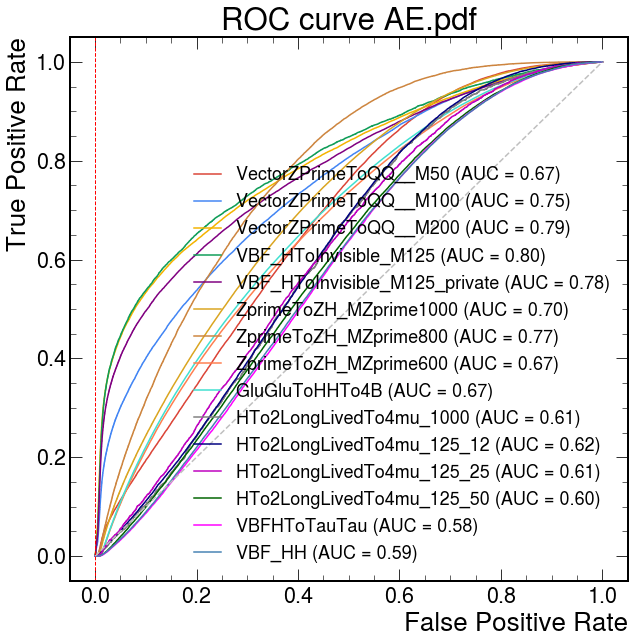

In [48]:
plt.figure(figsize=(10,10))
for key in results.keys():
    if key=='QCD': continue

    true_label = np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))
    pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
plt.legend(fontsize='x-small')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
plt.title('ROC curve '+model_type+'.pdf')

In [46]:
np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))

array([1., 1., 1., ..., 0., 0., 0.])

In [42]:
results.keys()

dict_keys(['VectorZPrimeToQQ__M50', 'VectorZPrimeToQQ__M100', 'VectorZPrimeToQQ__M200', 'VBF_HToInvisible_M125', 'VBF_HToInvisible_M125_private', 'ZprimeToZH_MZprime1000', 'ZprimeToZH_MZprime800', 'ZprimeToZH_MZprime600', 'GluGluToHHTo4B', 'HTo2LongLivedTo4mu_1000', 'HTo2LongLivedTo4mu_125_12', 'HTo2LongLivedTo4mu_125_25', 'HTo2LongLivedTo4mu_125_50', 'VBFHToTauTau', 'VBF_HH', 'QCD'])

In [7]:
# save model
model_json = autoencoder.to_json()
with open(output_model_json, 'w') as json_file:
    json_file.write(model_json)
autoencoder.save_weights(output_model_h5)

# save training history
with open(output_history, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)	

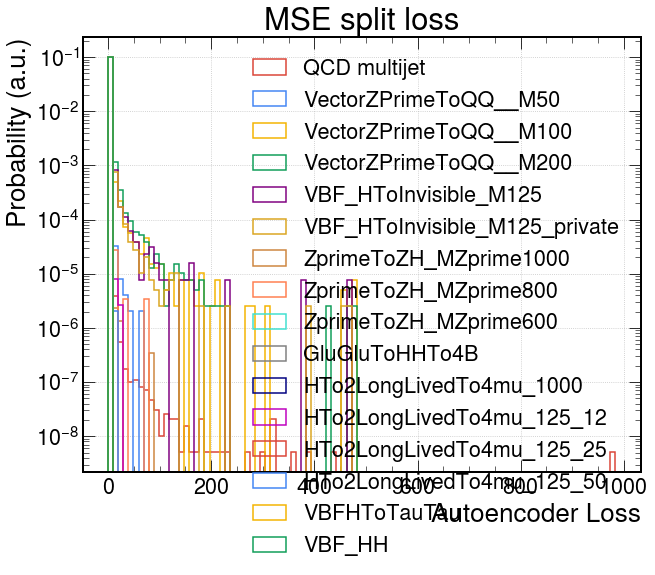

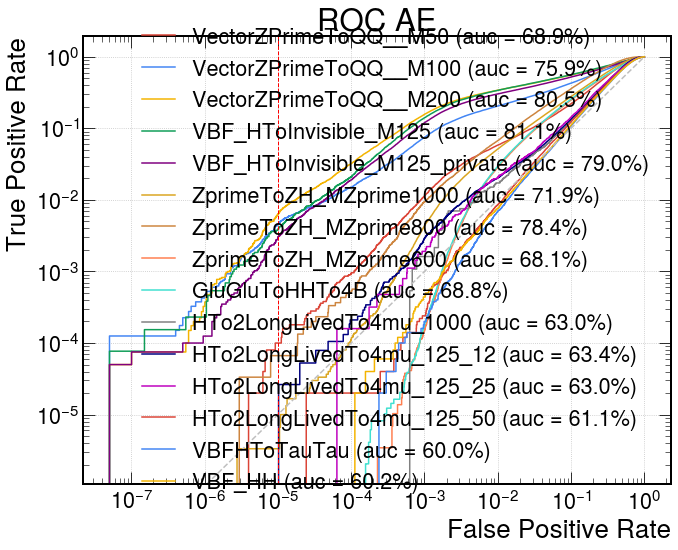

In [16]:
def return_total_loss(loss, X, qcd_pred, bsm_t, bsm_pred):
    
    total_loss = []
    total_loss.append(loss(X, qcd_pred.astype(np.float32)))
    for i, bsm_i in enumerate(bsm_t):
        total_loss.append(loss(bsm_i, bsm_pred[i].astype(np.float32)))
    return total_loss

loss = make_mse_loss_numpy
total_loss = return_total_loss(loss, X_test_scaled, qcd_prediction.numpy(), bsm_target, bsm_prediction)

labels = ['QCD multijet', 
          'VectorZPrimeToQQ__M50',
          'VectorZPrimeToQQ__M100',
          'VectorZPrimeToQQ__M200',
          'VBF_HToInvisible_M125',
          'VBF_HToInvisible_M125_private',
          'ZprimeToZH_MZprime1000',
          'ZprimeToZH_MZprime800',
          'ZprimeToZH_MZprime600',
          'GluGluToHHTo4B',
          'HTo2LongLivedTo4mu_1000',
          'HTo2LongLivedTo4mu_125_12',
          'HTo2LongLivedTo4mu_125_25',
          'HTo2LongLivedTo4mu_125_50',
          'VBFHToTauTau',
          'VBF_HH'] 

minScore = 999999.
maxScore = 0
for i in range(len(labels)):
    thisMin = np.min(total_loss[i])
    thisMax = np.max(total_loss[i])
    minScore = min(thisMin, minScore)
    maxScore = max(maxScore, thisMax)

bin_size=100
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True,
         histtype='step', fill=False, linewidth=1.5, range=(minScore, maxScore))
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.title('MSE split loss')
plt.legend(loc='best')
plt.show()
# plt.savefig(f'{output_dir}/losses.pdf', facecolor='white')


####### ROC curves
labels_legend = ['VectorZPrimeToQQ__M50',
                 'VectorZPrimeToQQ__M100',
                'VectorZPrimeToQQ__M200',
                'VBF_HToInvisible_M125',
                'VBF_HToInvisible_M125_private',
                'ZprimeToZH_MZprime1000',
                'ZprimeToZH_MZprime800',
                'ZprimeToZH_MZprime600',
                'GluGluToHHTo4B',
                'HTo2LongLivedTo4mu_1000',
                'HTo2LongLivedTo4mu_125_12',
                'HTo2LongLivedTo4mu_125_25',
                'HTo2LongLivedTo4mu_125_50',
                'VBFHToTauTau',
                'VBF_HH']


from sklearn.metrics import roc_curve, auc

target_qcd = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_qcd))
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(labels_legend[i-1],auc_loss*100.), linewidth=1.5)
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.grid(True)
    plt.legend(loc='center right')
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
plt.title("ROC AE")
plt.show()

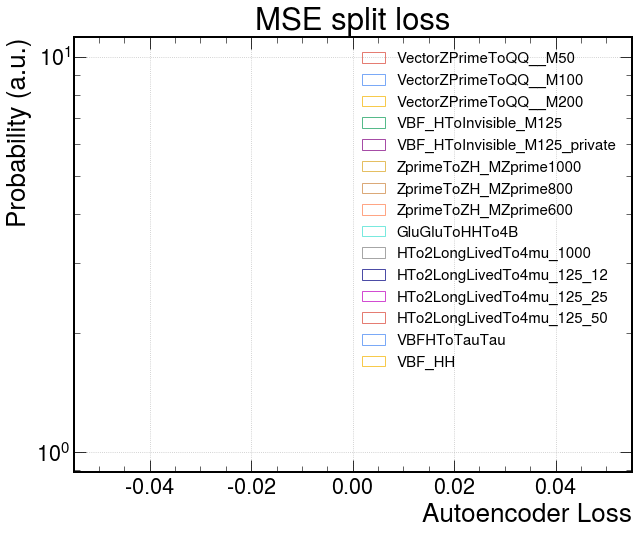

In [17]:
plt.figure(figsize=(10,8))
bins_ =np.arange(0, 500,1000)

# plt.hist(qcd_loss,color='k', label ='QCD', histtype='step', fill=False,alpha=1,linewidth=2,density=True )


for key in bsm_results.keys():
    plt.hist(bsm_results[key][2], bins = bins_ , label =key, histtype='step', fill=False,alpha=0.7,density=True )

plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.title('MSE split loss')
plt.legend(loc='best',fontsize="xx-small")
plt.yscale('log')
plt.show()

In [19]:
bsm_results['VectorZPrimeToQQ__M100'][2]

array([1.9335996, 3.4058404, 2.3006725, ..., 2.5391781, 1.7657666,
       2.0332246], dtype=float32)

In [20]:
np.histogram(bsm_results['VectorZPrimeToQQ__M100'][2])

(array([39758,    56,    15,     9,     5,     2,     1,     0,     0,
            5]),
 array([2.0545157e-02, 4.7923702e+01, 9.5826859e+01, 1.4373003e+02,
        1.9163318e+02, 2.3953633e+02, 2.8743948e+02, 3.3534265e+02,
        3.8324582e+02, 4.3114896e+02, 4.7905212e+02], dtype=float32))

In [26]:
max(losses)

518.8463

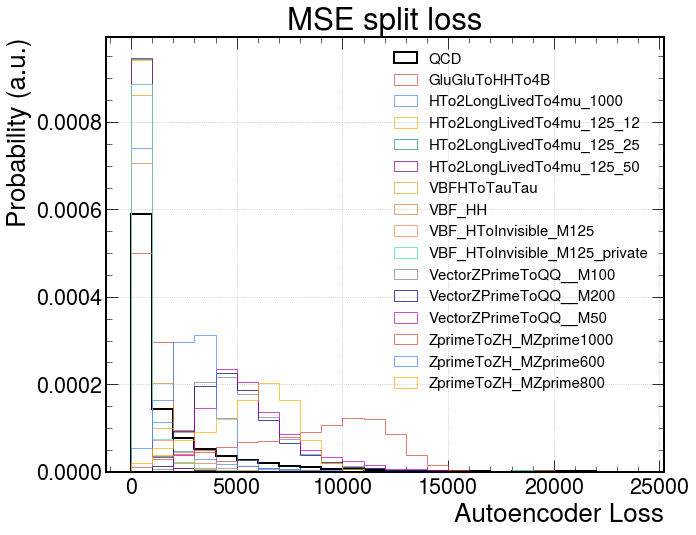

In [35]:
plt.figure(figsize=(10,8))
bins_ =np.arange(min(losses),25000,1000)

plt.hist(qcd_loss, bins = bins_ ,color='k', label ='QCD', histtype='step', fill=False,alpha=1,linewidth=2,density=True )

for key in bsm_results.keys():
    plt.hist(bsm_results[key][2], bins = bins_ , label =key, histtype='step', fill=False,alpha=0.7,density=True )

plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.title('MSE split loss')
plt.legend(loc='best',fontsize="xx-small")
plt.show()

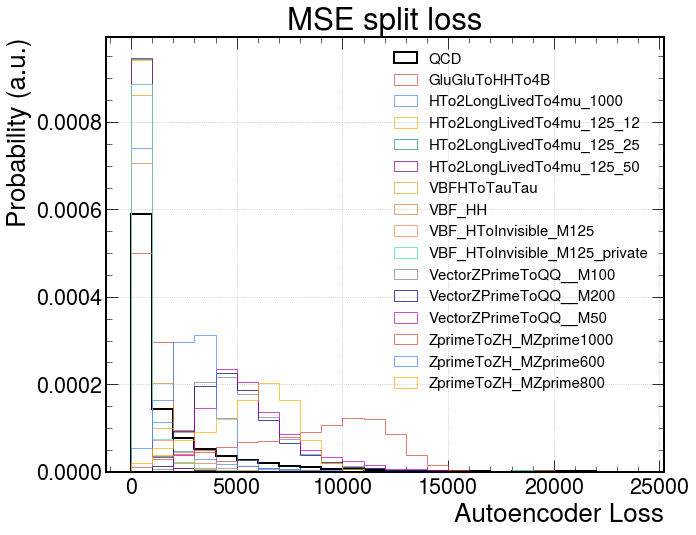

In [32]:
plt.figure(figsize=(10,8))
bins_ =np.arange(min(losses),25000,1000)

plt.hist(qcd_loss, bins = bins_ ,color='k', label ='QCD', histtype='step', fill=False,alpha=1,linewidth=2,density=True )

for key in bsm_results.keys():
    plt.hist(bsm_results[key][2], bins = bins_ , label =key, histtype='step', fill=False,alpha=0.7,density=True )

plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.title('MSE split loss')
plt.legend(loc='best',fontsize="xx-small")
plt.show()

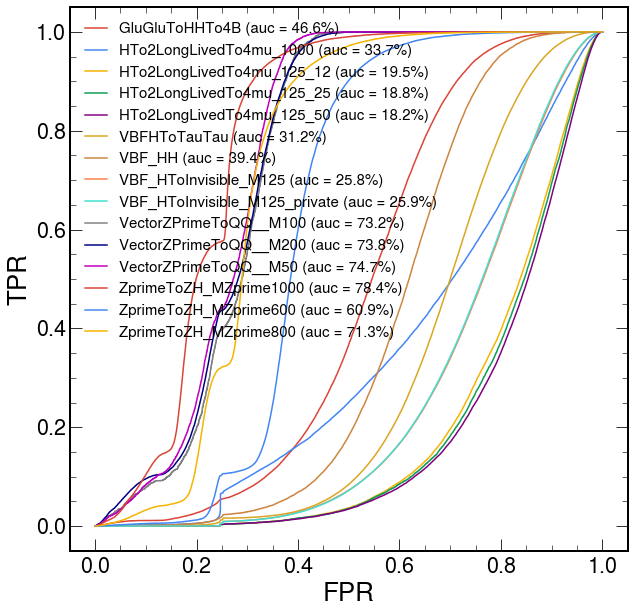

In [19]:
for key in bsm_results.keys():
    classes =np.concatenate((np.ones(bsm_results[key][2].shape[0]), np.zeros(qcd_loss.shape[0])))
    predictions = np.concatenate((bsm_results[key][2], qcd_loss))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(classes, predictions)
    auc_loss=auc(fpr_loss, tpr_loss)
    bsm_results[key].extend([fpr_loss, tpr_loss, threshold_loss,auc_loss])
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(key,auc_loss*100.), linewidth=1.5)

plt.xlabel("FPR",loc='center')
plt.ylabel("TPR",loc='center')
plt.legend(loc='best',fontsize="xx-small")

In [80]:
auc(fpr_loss, tpr_loss)

0.707164